## Introduction

- This kernel is dedicated to implementing various feature engineering methodologies which is quite essential in Applied machine learning. The main objective is to maximize the score and achive higher rank using various techniques.

- This kernel is referenced by [Feature Engineering Kaggle Course](https://www.kaggle.com/learn/feature-engineering) and few other blog posts which are mentioned in the end.

- The data used in this notebook is provided in the [Talking Data ADtracking fraud detection Competition](https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection)

### Feature Engineering:

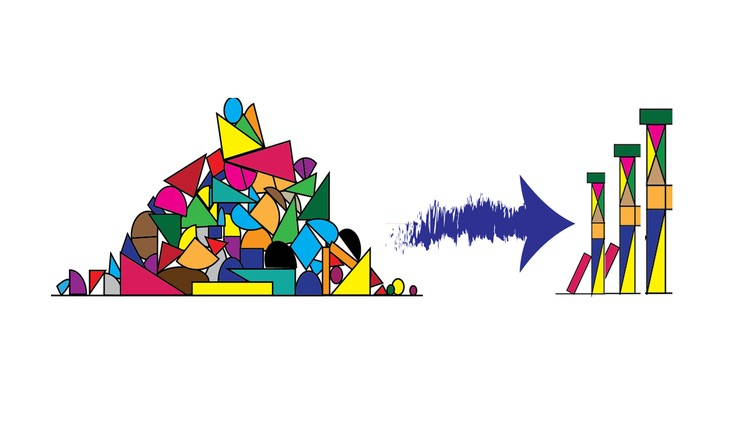


### Data Description

- `ip:` ip address of click.

- `app:` app id for marketing.

- `device:` device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)

- `os:` os version id of user mobile phone

- `channel:` channel id of mobile ad publisher

- `click_time:` timestamp of click (UTC)

- `attributed_time:` if user download the app for after clicking an ad, this is the time of the app download

- **`is_attributed:`** the target that is to be predicted, indicating the app was downloaded **[target Variable]**

Test data is similar, with the following differences:

- `click_id:` reference for making predictions

- `is_attributed:` not included

### Content:

- Data Preparation

- Extracting features of timmestamp.

- Label Encoding

- Light GBM Modelling

- Encoding categorical features:
   
   `1. Count Encoding`
    
   `2. Target Encoding`
   
   `3. CatBoost Encoding`
    
- Feature Generation
    
    `1. Interactions`
    
    `2. Last Activity` 
    
    `3. Time since last activity`
    
    `4. Past downloads`

- Test Data Preparation

- Submissions.


### Let's Begin.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode()
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns

In [ ]:
import pandas as pd

click_data = pd.read_csv('../input/talkingdata-adtracking-fraud-detection/train_sample.csv',parse_dates=['click_time'])

In [ ]:
click_data.head()

In [ ]:
print("Shape of click_data is : {}".format(click_data.shape))

In [ ]:
# Add new columns for timestamp features day, hour, minute, and second

clicks = click_data.copy()
clicks['day'] = clicks['click_time'].dt.day.astype('uint8')
clicks['hour'] = clicks['click_time'].dt.hour.astype('uint8')
clicks['minute'] = clicks['click_time'].dt.minute.astype('uint8')
clicks['second'] = clicks['click_time'].dt.second.astype('uint8')

In [ ]:
clicks.head()

## [Label Encoding:](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

- Giving labels to categorical features.

In [ ]:
from sklearn import preprocessing

cat_features = ['ip', 'app', 'device', 'os', 'channel']
lable_encoder = preprocessing.LabelEncoder()

for feature in cat_features:
    encoded = lable_encoder.fit_transform(clicks[feature])
    clicks[feature +'_labels'] = encoded

In [ ]:
clicks.head()

In [ ]:
feature_cols = ['day', 'hour', 'minute', 'second', 
                'ip_labels', 'app_labels', 'device_labels',
                'os_labels', 'channel_labels']

valid_fraction = 0.1
clicks_srt = clicks.sort_values('click_time')
valid_rows = int(len(clicks_srt) * valid_fraction)
train = clicks_srt[:-valid_rows * 2]
valid = clicks_srt[-valid_rows * 2:-valid_rows]
test = clicks_srt[-valid_rows:]

In [ ]:
train.head()

In [ ]:
valid.head()

In [ ]:
test.head()

### Missing Values.

In [ ]:
# msno.bar(train)

plt.style.use('seaborn-colorblind')
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

msno.bar(train, ax = ax1, color=(10/255, 3/255, 250/255), fontsize=10)
msno.bar(test, ax = ax2, color=(251/255, 0/255, 0/255), fontsize=10)

ax1.set_title('Train Missing Values Map', fontsize = 16)
ax2.set_title('Test Missing Values Map', fontsize = 16);

### Target Variable Analysis.

### Training Data

In [ ]:
plt.style.use('dark_background')
plt.figure(figsize=(10,8))  
# sns.set(style="darkgrid")
ax = sns.countplot(x = train['is_attributed'])

### Validation Data

In [ ]:
plt.style.use('dark_background')
plt.figure(figsize=(10,8))  
# sns.set(style="darkgrid")
ax = sns.countplot(x = valid['is_attributed'])

### Test Data

In [ ]:
plt.style.use('dark_background')
plt.figure(figsize=(10,8))  
# sns.set(style="darkgrid")
ax = sns.countplot(x = test['is_attributed'])

### Modelling.

In [ ]:
import lightgbm as lgb

dtrain = lgb.Dataset(train[feature_cols], label=train['is_attributed'])
dvalid = lgb.Dataset(valid[feature_cols], label=valid['is_attributed'])
dtest = lgb.Dataset(test[feature_cols], label=test['is_attributed'])

param = {'num_leaves': 64, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=3)

In [ ]:
from sklearn import metrics

ypred = bst.predict(test[feature_cols])
score = metrics.roc_auc_score(test['is_attributed'], ypred)
print(f"Test score: {score}")

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, metrics
import lightgbm as lgb

clicks = pd.read_parquet('../input/feature-engineering-data/baseline_data.pqt')

## Baseline Model:

- The model used here is Light GBM(Gradient Boosting Method).

#### **Why LightGBM**

- Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks.

- Since it is based on decision tree algorithms, it splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. 

- So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms.

- Also, it is surprisingly **very fast, hence the word ‘Light’.**

Source: [Light GBM vs XGBoost](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/)

In [ ]:
def get_data_splits(dataframe, valid_fraction=0.1):
    """Splits a dataframe into train, validation, and test sets.

    First, orders by the column 'click_time'. Set the size of the 
    validation and test sets with the valid_fraction keyword argument.
    """

    dataframe = dataframe.sort_values('click_time')
    valid_rows = int(len(dataframe) * valid_fraction)
    train = dataframe[:-valid_rows * 2]

    valid = dataframe[-valid_rows * 2:-valid_rows]
    test = dataframe[-valid_rows:]
    
    return train, valid, test

def train_model(train, valid, test=None, feature_cols=None):
    if feature_cols is None:
        feature_cols = train.columns.drop(['click_time', 'attributed_time',
                                           'is_attributed'])
    dtrain = lgb.Dataset(train[feature_cols], label=train['is_attributed'])
    dvalid = lgb.Dataset(valid[feature_cols], label=valid['is_attributed'])
    
    param = {'num_leaves': 64, 'objective': 'binary', 
             'metric': 'auc', 'seed': 7}
    num_round = 1000
    bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], 
                    early_stopping_rounds=20, verbose_eval=False)
    
    valid_pred = bst.predict(valid[feature_cols])
    valid_score = metrics.roc_auc_score(valid['is_attributed'], valid_pred)
    print(f"Validation AUC score: {valid_score}")
    
    if test is not None: 
        test_pred = bst.predict(test[feature_cols])
        test_score = metrics.roc_auc_score(test['is_attributed'], test_pred)
        return bst, valid_score, test_score
    else:
        return bst, valid_score

In [ ]:
print("Baseline model")
train, valid, test = get_data_splits(clicks)
_ = train_model(train, valid)

## Encoding the categorical features: 

- As the data is split into train and validation set encoding will not overestimate the model's performance that means there will be not any kind of Data leakages.

- All of them will be executed using [category_encoders package](https://github.com/scikit-learn-contrib/category_encoders).

### 1. Count Encoding

### 2. Target Encoding

### 3. CatBoost Encoding.

## Count Encoding:

- The concept is quite simple, it's basically **replacing categorical variables by it's count.**
- Count Encoding just requires the categorical variables when instantiated.


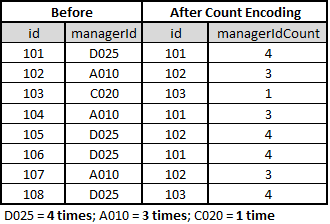

Image Credits: [Socrates Data Science Blog](https://blog.socratesk.com/blog/2018/06/17/featuren-engineering-and-extraction)

In [ ]:
import category_encoders as ce

cat_features = ['ip', 'app', 'device', 'os', 'channel']
train, valid, test = get_data_splits(clicks)

In [ ]:
import category_encoders as ce

count_enc = ce.CountEncoder(cols=cat_features)

count_enc.fit(train[cat_features])

train_encoded = train.join(count_enc.transform(train[cat_features]).add_suffix("_count"))
valid_encoded = valid.join(count_enc.transform(valid[cat_features]).add_suffix("_count"))

In [ ]:
_ = train_model(train_encoded, valid_encoded)

## Target Encoding:

-  It is based on encoding categorical variable values with mean of **target variable per value.**
- Target Encoding requires a target variable when instantiated.
- In this case feature **"is_attributed"** is the target variable.

- **NOTE: When using target variable, it is very important not to leak any information into the validation set(Data Leakage). Every such feature should be computed on the training set and then only merged or concatenated with the validation and test subsets.**

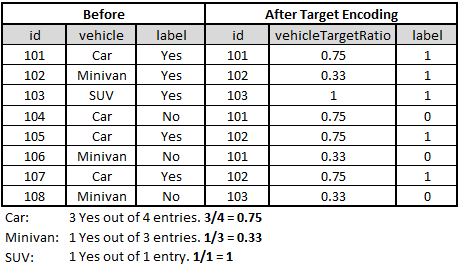

Image Credits: [Socrates Data Science Blog](https://blog.socratesk.com/blog/2018/06/17/featuren-engineering-and-extraction)

In [ ]:
import category_encoders as ce


target_enc = ce.TargetEncoder(cols = cat_features)

target_enc.fit(train[cat_features], train['is_attributed'])

train_encoded = train.join(target_enc.transform(train[cat_features]).add_suffix("_target"))

valid_encoded = valid.join(target_enc.transform(valid[cat_features]).add_suffix("_target"))

In [ ]:
# train_encoded = train_encoded.drop(['ip_target'],axis = 1)
# valid_encoded = valid_encoded.drop(['ip_target'],axis = 1)
_ = train_model(train_encoded, valid_encoded)

## CatBoost Encoding:



In [ ]:

cat_features = ['app', 'device', 'os', 'channel']

cb_enc = ce.CatBoostEncoder(cols=cat_features, random_state=7)

cb_enc.fit(train[cat_features], train['is_attributed'])

train_encoded = train.join(cb_enc.transform(train[cat_features]).add_suffix('_cb'))
valid_encoded = valid.join(cb_enc.transform(valid[cat_features]).add_suffix('_cb'))

In [ ]:
_ = train_model(train_encoded, valid_encoded)

## [Feature Generation.](https://www.kaggle.com/matleonard/feature-generation)

### 1. Interactions

### 2. Last Activity 

### 3. Time since last activity

### 4. Past downloads

## 1. Interactions:

- As the name suggest interactions is a method of combining two features in order to up the performance of the model.

- What we have done here is we have combine the categorical features together to obtain some new features.

- If you wanna go deeper into this I found this article helpful: [Interactions by christophm](https://christophm.github.io/interpretable-ml-book/interaction.html)

- The features we will create are: 

`interaction_features = ['ip_app','ip_device', 'ip_os', 'ip_channel', 'app_device', 
'app_os','app_channel', 'device_os','device_channel', 'os_channel']`

In [ ]:
import itertools

cat_features = ['ip', 'app', 'device', 'os', 'channel']
interactions = pd.DataFrame(index=clicks.index)

# Iterate through each pair of features, combine them into interaction features

for c1, c2 in itertools.combinations(cat_features,2):
    new_col = '_'.join([c1,c2])
    values = clicks[c1].map(str) + "_" + clicks[c2].map(str)
    encoder = preprocessing.LabelEncoder()
    interactions[new_col] = encoder.fit_transform(values)

In [ ]:
clicks = clicks.join(interactions)
print("Score with interactions")
train, valid, test = get_data_splits(clicks)
_ = train_model(train, valid)

In [ ]:
interaction_features = ['ip_app','ip_device', 'ip_os', 'ip_channel', 'app_device', 'app_os','app_channel', 'device_os', 
                        'device_channel', 'os_channel']
clicks[interaction_features].head()

## Activity

- This feature will give the number of events from the same IP in the last six hours. It's likely that someone who is visiting often will download the app.

- The function count_past_events will execute the process using a random series.

In [ ]:
def count_past_events(series):
    activity = pd.Series(series.index, index = series, name="past_6_hours").sort_index()
    past_6_hours = activity.rolling('6H').count() - 1
    return past_6_hours

- As this dataset is huge calculating activity of each ip for past 6 hours can be a lot time consuming step.
- So I have used the dataset provided by [Matt Leonard](https://www.kaggle.com/matleonard) for these files.

- Credits: [feature engineering data](https://www.kaggle.com/matleonard/feature-engineering-data)

In [ ]:
past_events = pd.read_parquet('../input/feature-engineering-data/past_6hr_events.pqt')
clicks['ip_past_6hr_counts'] = past_events

train, valid, test = get_data_splits(clicks)
_ = train_model(train, valid)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(clicks.ip_past_6hr_counts[6:]);
plt.title("Activity of ip within 6 hrs");

## Time since last activity

In [ ]:
def time_diff(series):
    """Returns a series with the time since the last timestamp in seconds."""
    return series.diff().dt.total_seconds()

In [ ]:
past_events = pd.read_parquet('../input/feature-engineering-data/time_deltas.pqt')
clicks['past_events_6hr'] = past_events

train, valid, test = get_data_splits(clicks.join(past_events))
_ = train_model(train, valid)

## Number of previous Downloads

In [ ]:
def previous_attributions(series):
    """Returns a series with the number of times an app has been downloaded."""
    sums = series.expanding(min_periods=2).sum() - series
    return sums

In [ ]:
past_events = pd.read_parquet('../input/feature-engineering-data/downloads.pqt')
clicks['ip_past_6hr_counts'] = past_events

train, valid, test = get_data_splits(clicks)
_ = train_model(train, valid)

## Preparing Test Data.

In [ ]:
test = pd.read_csv('../input/talkingdata-adtracking-fraud-detection/test.csv',
                         parse_dates=['click_time'])
test.head()

In [ ]:
# feature_cols = ['day', 'hour', 'minute', 'second', 
#                 'ip_labels', 'app_labels', 'device_labels',
#                 'os_labels', 'channel_labels']

test_x = test.copy()
test_x['day'] = test_x['click_time'].dt.day.astype('uint8')
test_x['hour'] = test_x['click_time'].dt.hour.astype('uint8')
test_x['minute'] = test_x['click_time'].dt.minute.astype('uint8')
test_x['second'] = test_x['click_time'].dt.second.astype('uint8')

In [ ]:
from sklearn import preprocessing

cat_features = ['ip', 'app', 'device', 'os', 'channel']
lable_encoder = preprocessing.LabelEncoder()

for feature in cat_features:
    encoded = lable_encoder.fit_transform(test_x[feature])
    test_x[feature +'_labels'] = encoded

In [ ]:
test_x.head()

In [ ]:
test_x = test_x.drop(["click_time","ip","channel","click_id","app","device","os"], axis = 1)
test_x.head()

In [ ]:
predictions = bst.predict(test_x)
print(predictions.shape)

predict = np.array(predictions)
predict = np.around(predict,decimals = 0)

In [ ]:
data = {
    "click_id": test.click_id,
    "is_attributed": predict
}
sub = pd.DataFrame(data = data)
sub['is_attributed'] = sub['is_attributed'].astype(int)
# sub.to_csv("submission.csv",index = False)
sub.head()

**This is just a basic model which achieved score of 0.703**
- Alot can be done with it and there is a huge scope of improvement which will come up future versions.


## References:

1. [Feature Engineering Kaggle Course](https://www.kaggle.com/learn/feature-engineering)

2. [Wronsinski Github Blog on Categorical Encoding](https://wrosinski.github.io/fe_categorical_encoding/)

3. [Talking Data ADtracking fraud detection Competition](https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection)

4. [Feature Engineering Data](https://www.kaggle.com/matleonard/feature-engineering-data)

5. [Light GBM Documentation](https://lightgbm.readthedocs.io/en/latest)


**This is the end of this kernel. Feel free to fork and if you found this useful do upvote.**